In [18]:
import pickle

import bento
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import os
import pickle

import bento
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from optuna.integration import SkorchPruningCallback
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skorch import NeuralNet, NeuralNetClassifier
from skorch.callbacks import EarlyStopping, EpochScoring
from xgboost import XGBRFClassifier

In [3]:
data = bento.io.read_h5ad("../../data/locfish/locfish_eval_20211019.h5ad")
data.shape

(10000, 1)

In [4]:
point_features = bento.tl.list_point_features()
shape_features = bento.tl.list_shape_features()
# print("Point Features:", point_features)
# print("Shape Features:", shape_features)

In [5]:
# cell_by_feature = bento.tl.get_features(
#     data, bento.tl.PATTERN_MODEL_FEATURE_NAMES, min_count=0
# )

# cell_by_feature.head()

In [6]:
# List of features
features = [
    "cell_inner_proximity",
    "nucleus_inner_proximity",
    "nucleus_outer_proximity",
    "cell_inner_asymmetry",
    "nucleus_inner_asymmetry",
    "nucleus_outer_asymmetry",
    "l_max",
    "l_max_gradient",
    "l_min_gradient",
    "l_monotony",
    "l_half_radius",
    "point_dispersion",
    "nucleus_dispersion",
]

cell_by_feature = []
for f in features:
    cell_by_feature.append(data.to_df(f))
cell_by_feature = (
    pd.concat(cell_by_feature, axis=1).reset_index(drop=True).astype(float)
)
cell_by_feature.columns = features

In [7]:
# print(dir(bento.tl))


# print(dir(bento._utils))


## Prepare datasets

In [8]:
# classes = bento._utils.PATTERN_NAMES

In [9]:
classes = ["cell_edge", "cytoplasmic", "none", "nuclear", "nuclear_edge"]

Split train/test features

In [10]:
X = cell_by_feature.to_numpy()

le = LabelBinarizer().fit(classes)
y = le.transform(data.to_df("pattern").values.flatten())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=22, stratify=y
)

# Calibrate model

In [11]:
model = pickle.load(open(f"../../models/ml_multilabel_20211102/rf_model.pkl", "rb"))

In [12]:
prob_pos_clf = model.predict_proba(X_test)

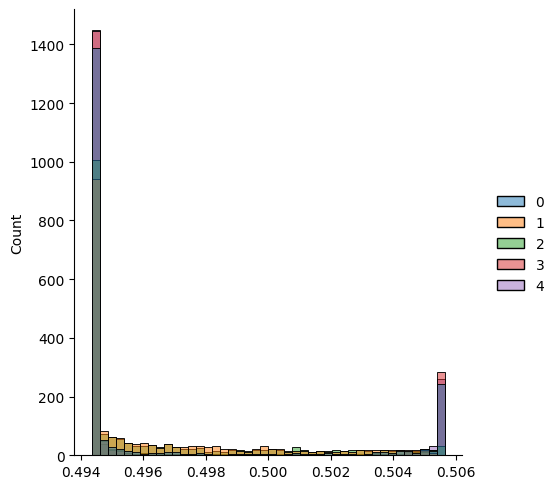

In [13]:
sns.displot(prob_pos_clf)

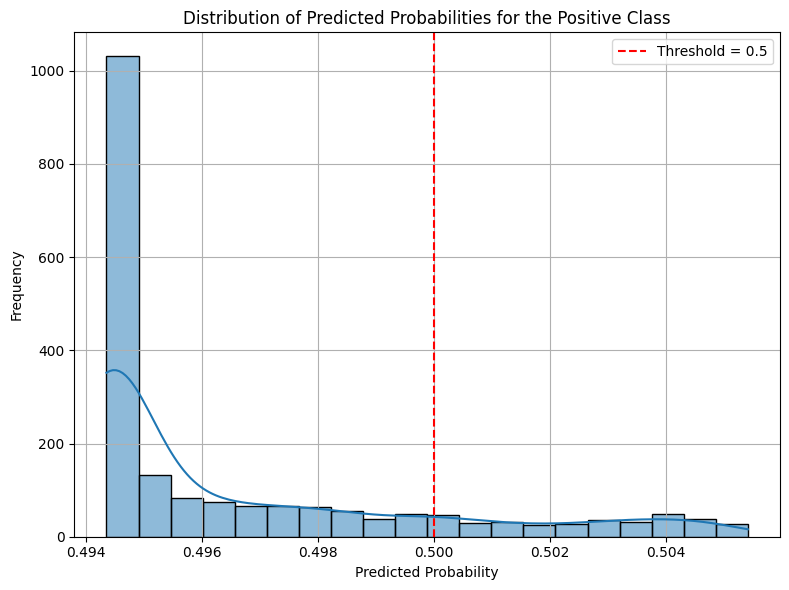

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming prob_pos_clf is the probability for the positive class from the model
# If prob_pos_clf is an array of shape (n_samples, 2) (e.g., for binary classification),
# use the probabilities of the positive class (typically column 1).
prob_pos = prob_pos_clf[:, 1]

# Create the distribution plot with additional details
plt.figure(figsize=(8, 6))
sns.histplot(prob_pos, bins=20, kde=True)
plt.title('Distribution of Predicted Probabilities for the Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend()
plt.tight_layout()
plt.show()


With isotonic calibration

In [26]:
clf_isotonic = CalibratedClassifierCV(model, cv="prefit", method="isotonic")
clf_isotonic.fit(X_test, y_test)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)

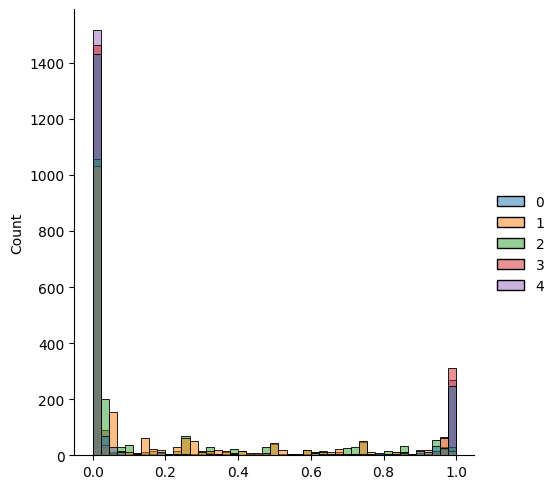

In [27]:
sns.displot(clf_isotonic.predict_proba(X_test))

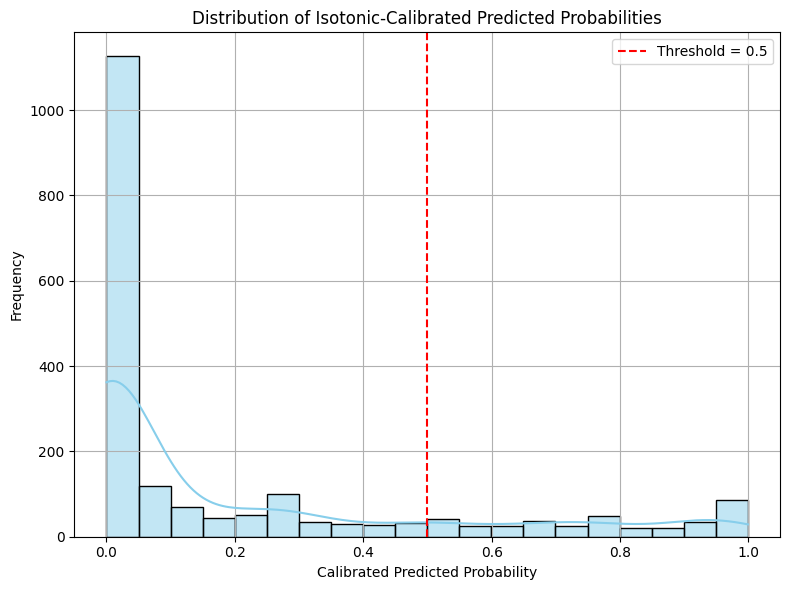

In [16]:
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming model is the uncalibrated model you've already fitted
clf_isotonic = CalibratedClassifierCV(model, cv="prefit", method="isotonic")
clf_isotonic.fit(X_test, y_test)

# Get calibrated probabilities for the positive class (usually column 1 in binary classification)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Plot the distribution of calibrated probabilities
plt.figure(figsize=(8, 6))
sns.histplot(prob_pos_isotonic, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Isotonic-Calibrated Predicted Probabilities')
plt.xlabel('Calibrated Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
print("Brier score losses: (the smaller the better)")

for i in range(5):
    clf_score = brier_score_loss(y_test[:, i], prob_pos_clf[:, i])
    print("No calibration: %1.3f" % clf_score)

for i in range(5):
    clf_isotonic_score = brier_score_loss(y_test[:, i], prob_pos_isotonic[:, i])
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

Brier score losses: (the smaller the better)
No calibration: 0.245
No calibration: 0.246
No calibration: 0.246
No calibration: 0.245
No calibration: 0.245
With isotonic calibration: 0.016
With isotonic calibration: 0.066
With isotonic calibration: 0.062
With isotonic calibration: 0.009
With isotonic calibration: 0.008


In [29]:
pickle.dump(clf_isotonic, open(f"../../models/rf_calib_20220514.pkl", "wb"))